# 1. Spot Model

**@juliaroquette** Here I am defining a simple spot model to derive typical spot induced variability amplitudes in widely used photometric bands. This is the same model I implemented for [Roquette et al. (2010)](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A.128R/abstract), but there I only applied it for the JHK near-infrared bands. 

In [20]:
import numpy as np
import astropy.units as u
import astropy.constants as q
import matplotlib.pyplot as plt

The first ingredient is a Plank curve as we assume that both the star and the spot emit like Black-Bodies. My BlackBody model will consider the irradiance of a body with temperature $T$ at a given wavelength $\lambda$. In my definition below, I am considering a sphere emitting (which introduces a $4\phi$ factor), although since we will be dividing $E_{e, spot}$ and $E_{e, star}$ in equation (2), this assumption won't cause any problm.

\begin{equation}
E_e(\lambda; T) = \frac{8\pi hc^2}{\lambda^5} ( \frac{1}{e^{\frac{hc}{\lambda kT}} - 1} )
\end{equation}

In [5]:
def myBlackBody(wl, Teff):
    """
    BlackBody equation considering a sphere irradiating. 
    Equation (1) above.
    """
    assert wl.decompose().unit == u.m
    assert Teff.unit == u.K
    B = (4. * np.pi * 2. * q.h * q.c**2 / wl**5) * 1 / (np.exp(q.h * q.c / (wl * q.k_B * Teff)) - 1)
    return B.to(u.W/u.m**2/u.m)

In [6]:
myBlackBody(500 * u.nm, 5000 * u.K)

<Quantity 1.52143444e+14 W / m3>

The amplitude of variability induced by a spot can be written as in [Bouvier et al. 1993](ttps://ui.adsabs.harvard.edu/abs/1993A%26A...272..176B/abstract):

\begin{equation}
\Delta m=-2.5\log{\Bigg(1-\frac{f}{1-\frac{\mu}{3}}\Bigg[1-\frac{B_\lambda(T_\mathrm{spot})}{B_\lambda(T_*)}\Bigg]\Bigg)},
\end{equation}

where:
- $m$ is the magnitude at a filter with a effective wavelength $\lambda$
- $T_{spot}$ and $T_{*}$ are the spot and stellar temperature respectively. 
- $f$ is the fraction of coverage by spots. 
- $\mu$ is the limb darkening coefficient for that filter

In [16]:
def Amp_spot(Teff, Tspot, wavelength, fraction_coverage, limb_darkening):
    assert Teff.unit == u.K
    assert Tspot.unit == u.K
    assert wavelength.decompose().unit == u.m
    return -2.5 * np.log10(1 - \
        (fraction_coverage / (1. - limb_darkening / 3.)) *\
            (1 - myBlackBody(wavelength, Tspot) / myBlackBody(wavelength,Teff)))

# 1.1 Limb-Darkening

The limb-darkening coefficients are from [Claret & Bloemen 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..75C/abstract)

In [8]:
from astropy.table import Table
limb_darkening_coefficients = Table.read('LimbDarkeningClaret&Blomen_2011.fit', format='fits')
len(limb_darkening_coefficients)

540736

For the moment, I will assume a $logg\approx4$ for YSOs and consider only solar metalicity ($Z = log[M/H] = 0$)

In [9]:
limb_darkening_coefficients = limb_darkening_coefficients[\
    (limb_darkening_coefficients['logg'] == 4.) &\
        (limb_darkening_coefficients['Z'] == 0.)]

 I will ignore the 'uvby' system as no one uses this nowadays. 

In [10]:
print(len(limb_darkening_coefficients))
for ft in ["u ", 'v ', 'b ', 'y ']:
    limb_darkening_coefficients = limb_darkening_coefficients[limb_darkening_coefficients['Filt'] != ft]
print(len(limb_darkening_coefficients))

18956
16108


I wll also drop temperatures larger than 7,300K, since I am interested in low-mass YSOs which will not be more massive than F0.

In [11]:
print(len(limb_darkening_coefficients))
limb_darkening_coefficients = limb_darkening_coefficients[limb_darkening_coefficients['Teff'] <= 7300.]
print(len(limb_darkening_coefficients))

16108
4280


In [12]:
limb_darkening_coefficients

logg,Teff,Z,xi,u,Filt,Met,Mod
[cm/s2],K,[Sun],km / s,,,,
float64,float64,float64,float64,float64,bytes2,bytes1,bytes2
4.0,3500.0,0.0,0.0,0.6846,Kp,L,A
4.0,3750.0,0.0,0.0,0.7109,Kp,L,A
4.0,4000.0,0.0,0.0,0.7545,Kp,L,A
4.0,4250.0,0.0,0.0,0.7548,Kp,L,A
4.0,4500.0,0.0,0.0,0.7308,Kp,L,A
4.0,4750.0,0.0,0.0,0.7058,Kp,L,A
4.0,5000.0,0.0,0.0,0.6798,Kp,L,A
4.0,5250.0,0.0,0.0,0.6524,Kp,L,A


Finally, I used the [SVO-database](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Generic&gname2=Johnson_UBVRIJHKL&asttype=) to retrieve some extra info on the filters for which they provide limb-darkening.

In [13]:
effective_wavelength = {
    'Kp': 5978.14*u.angstrom,
    'U': 3551.05*u.angstrom,
    'B': 4361.93*u.angstrom,
    'V': 5467.57*u.angstrom,
    'R': 6695.83*u.angstrom,
    'I': 8568.89*u.angstrom,
    'J': 12094.21*u.angstrom,
    'H': 16303.58*u.angstrom,
    'K': 21429.69*u.angstrom, 
    'S1': 35074.83*u.angstrom,
    'S2': 44365.56*u.angstrom,
    'S3': 56280.62*u.angstrom,
    'S4': 75890.54*u.angstrom,
    'C':  10895.94*u.angstrom,
    "g'": 5690.45*u.angstrom,
    "i'": 8730.62*u.angstrom,
    "r'": 7176.14*u.angstrom,
    "z'": 13500.00*u.angstrom,
    "u'": 3987.70*u.angstrom
}

In [14]:
Names = {
    'Kp': 'Kepler', 
    'U': 'Johnson-Cousin',
    'B': 'Johnson-Cousin',
    'V': 'Johnson-Cousin',
    'R': 'Johnson-Cousin',
    'I': 'Johnson-Cousin',
    'J': 'Johnson-Cousin',
    'H': 'Johnson-Cousin',
    'K': 'Johnson-Cousin',
    'S1': 'Spitzer/IRAC',
    'S2': 'Spitzer/IRAC',
    'S3': 'Spitzer/IRAC',
    'S4': 'Spitzer/IRAC',
    "u'": 'Sloan',
    "g'": 'Sloan',
    "r'": 'Sloan',
    "i'": 'Sloan',
    "z'": 'Sloan',
    'C': 'CoRoT'
}

### 1.1.1 Example for a cold spot 500 K colder than the star

In [19]:
limb_darkening_coefficients_ = limb_darkening_coefficients[limb_darkening_coefficients['Filt'] == 'C ']
T_spot_ = []
Teff_ = []
f_ = []
Amp_ = []
for i, Teff in enumerate(limb_darkening_coefficients_['Teff']):
    T_spot = (Teff - 500.)*u.K
    Teff = Teff*u.K
    for f in [0.1, 1, 10., 30.]:
        # print("T* {0}, Tspot {1}, f {2}, $\Delta$ m for CoRoT: {3}".format(Teff,\
            # T_spot, f, Amp_spot(Teff, T_spot, effective_wavelength['C'].to(u.m), f/100.,\
                # limb_darkening_coefficients_['u'][i])))
        T_spot_.append(T_spot)
        Teff_.append(Teff)
        f_.append(f/100.)
        Amp_.append(Amp_spot(Teff, T_spot, effective_wavelength['C'].to(u.m), f/100.,\
                limb_darkening_coefficients_['u'][i]))
    

0.00018508112429642892 0.6577679513786551


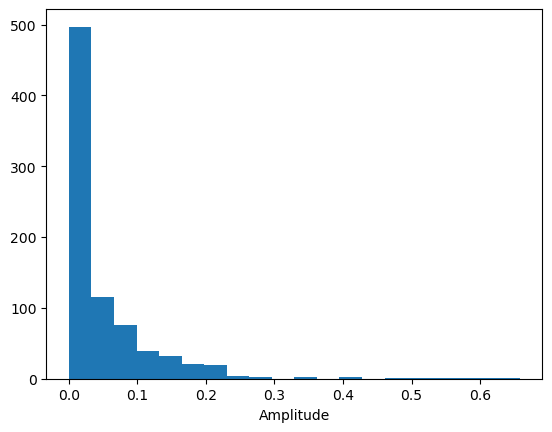

In [24]:
plt.hist(Amp_, bins=20)
plt.xlabel('Amplitude')
print(min(Amp_), max(Amp_))

## 1.2 Typical Spots in YSOs

The typical temperatures and spot coverages will be based on the spot parameters derived by [Venuti et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...581A..66V/abstract). This can be read from the table `Venuti15_spot_parameters.csv`, which has been processed by myself in the context of Roquette+2020 in order to transform Laura's spectral types into temperatures and use it to transform $\Delta T$ into spot and stellar temperatures. This file also contains some parameters published with Laura's paper, including the ground truth for their amplitudes in the $u$ and $r$ bands. Some of these parameters were retrieved from CDS, others were provided by Laura by private communication.

In [25]:
import pandas as pd
laura_spots = pd.read_csv('Venuti15_spot_parameters.csv')
laura_spots.head()

,Mon,SpT,Tspot,Teff,Feq(%),Flag,Class,umed,rmed,uamp,ramp,urms,rrms,slope,e_slope,_RA,_DE
0,57,M3,2697.376319,3357.376319,25.0,*,w,20.23,16.00,0.385,0.308,0.12,0.100,3.20,0.90,100.26641,9.96930
1,78,M3,3697.376319,3357.376319,10.0,*,w,22.14,18.09,0.315,0.134,0.09,0.040,0.50,0.30,100.25272,10.03735
2,80,M3,5597.376319,3357.376319,1.0,*,c,21.86,17.94,0.494,0.077,0.13,0.019,0.11,0.05,100.32481,10.06726
3,90,M3,3397.376319,3357.376319,59.0,*,c,20.44,16.72,0.664,0.371,0.16,0.100,1.22,0.10,100.28733,9.56280
4,102,M3,2497.376319,3357.376319,13.0,*,w,21.10,16.86,0.121,0.094,0.04,0.020,0.70,0.30,100.18014,9.52084


In [26]:
laura_spots['Delta_T'] = laura_spots['Tspot'] - laura_spots['Teff']

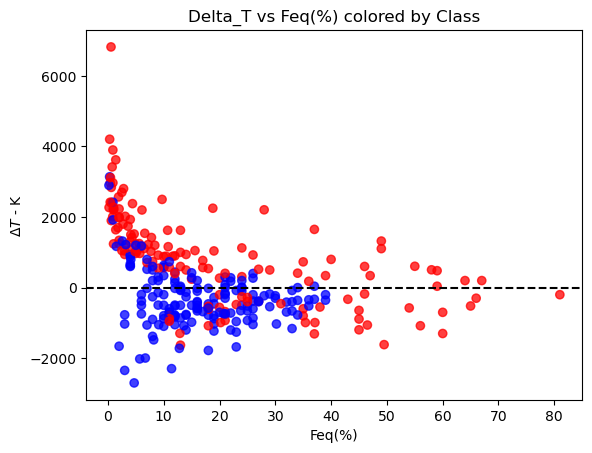

In [31]:
plt.scatter(laura_spots['Feq(%)'], laura_spots['Delta_T'], c=laura_spots['Class'].map({'c': 'red', 'w': 'blue'}), alpha=0.75)
plt.xlabel('Feq(%)')
plt.ylabel(r'$\Delta T$ - K')
plt.title('Delta_T vs Feq(%) colored by Class')
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [32]:
df_pos_w = laura_spots[(laura_spots['Delta_T'] > 0) & (laura_spots['Class'] == 'w')]
df_pos_c = laura_spots[(laura_spots['Delta_T'] > 0) & (laura_spots['Class'] == 'c')]
df_neg_w = laura_spots[(laura_spots['Delta_T'] < 0) & (laura_spots['Class'] == 'w')]
df_neg_c = laura_spots[(laura_spots['Delta_T'] < 0) & (laura_spots['Class'] == 'c')]

In [35]:
print('Cold Spot - WTTS', min(df_neg_w['ramp']), max(df_neg_w['ramp']))
print('Cold Spot - CTTS', min(df_neg_c['ramp']), max(df_neg_c['ramp']))
print('Hot Spot - WTTS', min(df_pos_w['ramp']), max(df_pos_w['ramp']))
print('Hot Spot - CTTS', min(df_pos_c['ramp']), max(df_pos_c['ramp']))

Cold Spot - WTTS 0.012 0.54
Cold Spot - CTTS 0.064 1.041
Hot Spot - WTTS 0.018 0.224
Hot Spot - CTTS 0.032 1.346


In [36]:
print('Cold Spot - WTTS', min(df_neg_w['Feq(%)']), max(df_neg_w['Feq(%)']))
print('Cold Spot - CTTS', min(df_neg_c['Feq(%)']), max(df_neg_c['Feq(%)']))
print('Hot Spot - WTTS', min(df_pos_w['Feq(%)']), max(df_pos_w['Feq(%)']))
print('Hot Spot - CTTS', min(df_pos_c['Feq(%)']), max(df_pos_c['Feq(%)']))

Cold Spot - WTTS 2.0 39.0
Cold Spot - CTTS 11.0 81.0
Hot Spot - WTTS 0.18 37.0
Hot Spot - CTTS 0.2 67.0


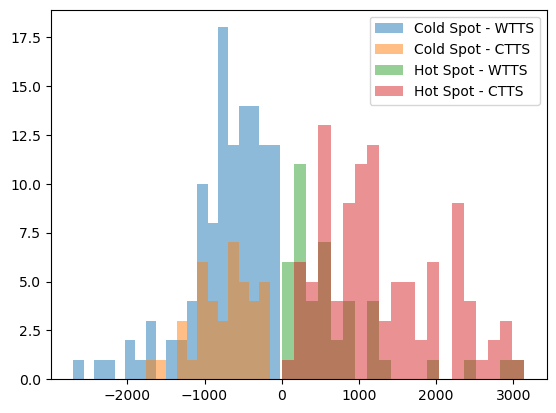

In [39]:
_ = plt.hist(df_neg_w['Delta_T'], bins=20, alpha=0.5, label='Cold Spot - WTTS')
plt.hist(df_neg_c['Delta_T'], bins=_[1], alpha=0.5, label='Cold Spot - CTTS')
_ = plt.hist(df_pos_w['Delta_T'], bins=20, alpha=0.5, label='Hot Spot - WTTS') 
plt.hist(df_pos_c['Delta_T'], bins=_[1], alpha=0.5, label='Hot Spot - CTTS')
plt.legend()

# TODO:

- Include calculations of amplitude for typical parameters in Venuti+15
- Include two spots
- Include a spot decay model 

# 2. Spot-decay model